# Data Science for Business - Subset Selection on Ames Housing

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import missingno as msno

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
plt.style.use('fivethirtyeight')

## Problem description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 76 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this dataset challenges you to predict the final price of each home. More: <https://www.kaggle.com/c/house-prices-advanced-regression-techniques>


## Load data

Load training data from CSV file.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/olivermueller/ds4b-2024/refs/heads/main/Session_05/ameshousing.csv')

In [4]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,20,RL,141,31770,Pave,none,IR1,Lvl,AllPub,Corner,...,0,0,0,none,0,5,2010,WD,Normal,215000
1,20,RH,80,11622,Pave,none,Reg,Lvl,AllPub,Inside,...,0,120,0,MnPrv,0,6,2010,WD,Normal,105000
2,20,RL,81,14267,Pave,none,IR1,Lvl,AllPub,Corner,...,0,0,0,none,12500,6,2010,WD,Normal,172000
3,20,RL,93,11160,Pave,none,Reg,Lvl,AllPub,Corner,...,0,0,0,none,0,4,2010,WD,Normal,244000
4,60,RL,74,13830,Pave,none,IR1,Lvl,AllPub,Inside,...,0,0,0,MnPrv,0,3,2010,WD,Normal,189900


In [5]:
data.shape

(2930, 77)

In [6]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF',

## Prepare data

First, we will remove some columns that are not useful for our task.

In [8]:
data = data.drop([ 'YrSold', 'MoSold', 'SaleCondition', 'SaleType'], axis=1)

In [9]:
data.shape

(2930, 73)

Next, we will split the data into features (*X*) and labels (*y*) and into training (*X_train, y_train*) and test (*X_test, y_test*) sets.

In [11]:
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Finally, we will do some feature engineering. It is important to use only information from the training set for feature engineering, and the mechanistically repeat these steps on the test set.

Typically, feature engineering depends strongly on the datatype of the variables. Hence, we will first determine which variables are categorical and which are numerical. Subsequentally, we will transform these variables seperately.

In [12]:
categorical_features = X_train.select_dtypes(include='object').columns
numerical_features = X_train.select_dtypes(exclude='object').columns

In [13]:
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence'],
      dtype='object')

In [14]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

The categorical variables must be transformed into numerical representations, e.g., by one-hot encoding them.

In [15]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(X_train[categorical_features])

X_train_cat = enc.transform(X_train[categorical_features])
X_test_cat = enc.transform(X_test[categorical_features])

X_train_cat = pd.DataFrame(X_train_cat, columns=enc.get_feature_names_out(categorical_features))
X_test_cat = pd.DataFrame(X_test_cat, columns=enc.get_feature_names_out(categorical_features))

In [16]:
X_train_cat.head()

,MSZoning_A(agr),MSZoning_C(all),MSZoning_FV,MSZoning_I(all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,...,GarageCond_TA,GarageCond_none,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_none
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The numerical variables will be standardized, that is, we will subtract the mean and divide by the standard deviation.

In [17]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

X_train_num = scaler.transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

X_train_num = pd.DataFrame(X_train_num, columns=numerical_features)
X_test_num = pd.DataFrame(X_test_num, columns=numerical_features)

In [19]:
X_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal
0,-0.871817,0.667826,0.033810,0.673941,-0.526415,0.181084,-0.381277,0.531409,-0.978369,-0.293998,...,0.614268,0.339813,0.047615,-0.753959,-0.695967,-0.369038,-0.098812,-0.286876,-0.067407,-0.09315
1,0.062906,-1.717704,2.307082,-0.766750,-0.526415,-0.115603,-0.814347,-0.569155,-0.427633,4.191480,...,-0.917482,0.339813,0.325180,3.139485,-0.695967,-0.369038,-0.098812,3.744734,-0.067407,-0.09315
2,0.763949,0.369635,-0.035514,-1.487095,-0.526415,-0.280430,-1.054941,-0.569155,-0.978369,-0.293998,...,-0.917482,0.339813,-0.032361,-0.753959,-0.695967,-0.369038,-0.098812,-0.286876,-0.067407,-0.09315
3,0.763949,0.071444,-0.363746,-1.487095,-0.526415,-0.708978,-1.632368,-0.569155,-0.978369,-0.293998,...,-0.917482,0.339813,-0.229950,-0.753959,-0.695967,-0.369038,-0.098812,-0.286876,-0.067407,-0.09315
4,3.100756,0.160901,-0.310697,-1.487095,0.378216,-1.664971,-1.632368,-0.569155,-0.978369,-0.293998,...,-0.917482,-2.337571,-2.205835,-0.753959,-0.695967,1.839369,-0.098812,-0.286876,-0.067407,-0.09315


Join categorical and numerical features.

In [20]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

In [21]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageCond_TA,GarageCond_none,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_none
0,-0.871817,0.667826,0.033810,0.673941,-0.526415,0.181084,-0.381277,0.531409,-0.978369,-0.293998,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.062906,-1.717704,2.307082,-0.766750,-0.526415,-0.115603,-0.814347,-0.569155,-0.427633,4.191480,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.763949,0.369635,-0.035514,-1.487095,-0.526415,-0.280430,-1.054941,-0.569155,-0.978369,-0.293998,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.763949,0.071444,-0.363746,-1.487095,-0.526415,-0.708978,-1.632368,-0.569155,-0.978369,-0.293998,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.100756,0.160901,-0.310697,-1.487095,0.378216,-1.664971,-1.632368,-0.569155,-0.978369,-0.293998,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Stepwise (forward/backward) feature selection

### Feature selection with pre-defined number of features

Let us first use the `SequentialFeatureSelector` to select a pre-defined number of features. We can use the *forward* and *backward* selection methods.

In [22]:
lm = LinearRegression()
sfs_fwd = SequentialFeatureSelector(lm, n_features_to_select=3, direction='forward', scoring="neg_root_mean_squared_error", cv=5)
sfs_fwd.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3,
                          scoring='neg_root_mean_squared_error')

Show the selected features. Note: The features are NOT listed in the order of their importance, but in the order they appear in the dataset!

In [23]:
sfs_fwd.get_feature_names_out()

array(['OverallQual', 'GrLivArea', 'BsmtQual_Ex'], dtype=object)

To see how well a model with this selected number of features performs, we will train it on the full training data and evaluate it on the test data.

In [25]:
mod_selected_features = LinearRegression().fit(X_train[sfs_fwd.get_feature_names_out()], y_train)
preds_selected_features = mod_selected_features.predict(X_test[sfs_fwd.get_feature_names_out()])
print(mean_squared_error(y_test, preds_selected_features))


1582920562.411216


## Compare models with different number of features

Now it's your turn! Compare the performance of models with different numbers of features (from 1 to 20). Hint: A for loop might be helpful here...

In [32]:
# YOUR CODE HERE
log = []
for i in range (1,10):
    entry = {}
    lm = LinearRegression()
    sfs_fwd = SequentialFeatureSelector(lm, n_features_to_select=i, direction='forward', scoring="neg_root_mean_squared_error", cv=3)
    sfs_fwd.fit(X_train, y_train)

    mod_selected_features = LinearRegression().fit(X_train[sfs_fwd.get_feature_names_out()], y_train)
    preds_selected_features = mod_selected_features.predict(X_test[sfs_fwd.get_feature_names_out()])

    entry['n_feature'] = i
    entry['feature_names'] = sfs_fwd.get_feature_names_out()
    entry['rmse'] = mean_squared_error(y_test, preds_selected_features)
    log.append(entry)


In [33]:
log_df = pd.DataFrame(log)
log_df

,n_feature,feature_names,rmse
0,1,[OverallQual],2.796155e+09
1,2,"[OverallQual, GrLivArea]",2.055416e+09
2,3,"[OverallQual, GrLivArea, BsmtQual_Ex]",1.582921e+09
3,4,"[OverallQual, BsmtFinSF1, GrLivArea, BsmtQual_Ex]",1.404421e+09
4,5,"[OverallQual, YearBuilt, BsmtFinSF1, GrLivArea...",1.346571e+09
5,6,"[MSSubClass, OverallQual, YearBuilt, BsmtFinSF...",1.243089e+09
6,7,"[MSSubClass, OverallQual, YearBuilt, BsmtFinSF...",1.171331e+09
7,8,"[MSSubClass, OverallQual, YearBuilt, BsmtFinSF...",1.140729e+09
8,9,"[MSSubClass, OverallQual, YearBuilt, BsmtFinSF...",1.114948e+09


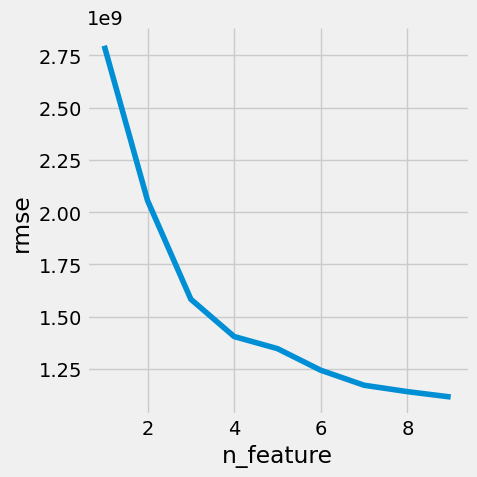

In [34]:
sns.relplot(data=log_df, x="n_feature", y="rmse", kind="line")